In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [2]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.2.0-rc2
Version 2, minor 2


Derived from

Keras blog: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Mount my Google Drive (have data stored there)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Download the Cats and Dogs dataset

- The raw dataset comes from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) and is quite a large archive file.  We only need one file
  - train.zip

- A **subset** of the training data was created, and organized as described [here](https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975)
  - Only 1000 training examples, 400 validation examples, per animal type
  - The notebook "Dogs_and_Cats_reformat" will perform this reformatting
- The reformatted, subset of the dataset (much smaller) was placed in an archive, which is read in this step



Unzip the Cats and Dogs images into pwd (i.e., /content).  That is where the code is looking


In [5]:
import os
!pwd

data_dir="data"
os.makedirs(data_dir, exist_ok=True)


if not (os.path.isdir("train") and os.path.isdir("validation") ):
  %cd $data_dir
  !tar -zxvf '/content/gdrive/My Drive/data/cats_and_dogs/cats_v_dogs.tgz'
  %cd ..


/content


The following is from [Blog script 1](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)

# Utility routines
Based on:  https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

def plot_training(history):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number
  
  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """  
  
  # Accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  
  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
import re
import IPython

def trainModel(model, train_data_dir, validation_data_dir):
  # compile the model with a SGD/momentum optimizer
  # and a very slow learning rate.
  model.compile(loss='binary_crossentropy',
                #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['acc'])

  # prepare data augmentation configuration
  train_datagen = ImageDataGenerator(
      rescale=1. / 255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='binary')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='binary')

  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                    # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
                ]   
  # fine-tune the model
  history = model.fit_generator(
      train_generator,
      # samples_per_epoch=nb_train_samples,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=callbacks
      )
  
  
  return history

def createTransferModel(base_model, last_base_layer_name, down_conv_features=32):
  model = Sequential()

  # Find the last layer
  layer_names = [ l.name for l in base_model.layers ]
  last_base_layer_idx = layer_names.index(last_base_layer_name)

  print("Last layer {ll:s} is index {i:d}".format(ll=last_base_layer_name, i=last_base_layer_idx))
  for i, layer in enumerate(base_model.layers[:last_base_layer_idx+1]):
    model.add(layer)
    layer.trainable=False
  
  # Add down sampling
  model.add( Conv2D(down_conv_features, kernel_size=(1, 1), activation='relu') )

  # Add head
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))


  return model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

# Problem description
- Binary classification problem, with small quantity of training data

- Cats and Dogs dataset:
  - a *small* number of examples
  - two classes: Cats, Dogs

Plan
1. Create and train own model
1. Transfer Learning
  - use the prefix of a pre-trained model
  - add own suffix
  

In [0]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

# dimensions of our images.
img_width, img_height = 150, 150
image_size = 150
IMG_SHAPE = (image_size, image_size, 3)

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


def createFirstModel():
  if tf.keras.backend.image_data_format() == 'channels_first':
      input_shape = (3, img_width, img_height)
  else:
      input_shape = (img_width, img_height, 3)

  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model


# Create own model
- multiple Conv2D/Pooling blocks


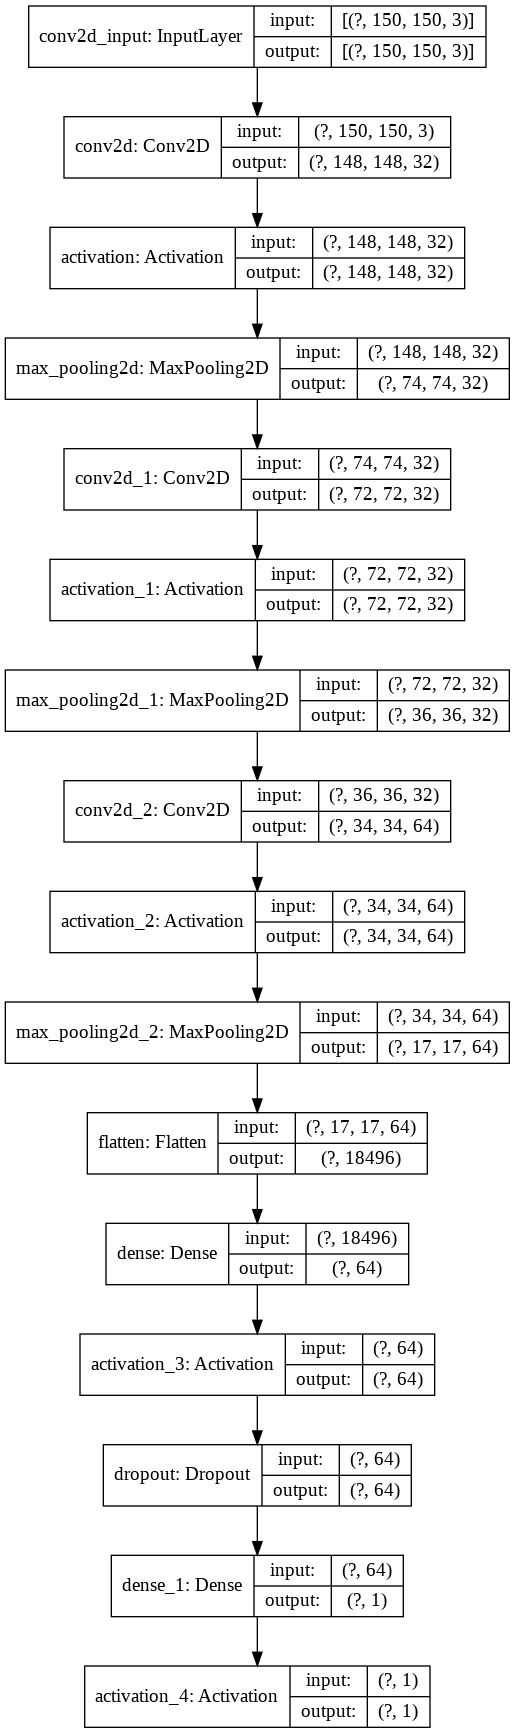

In [9]:
first_model = createFirstModel()
plotFile = plotModel(first_model, "first_model")
IPython.display.Image( plotFile) 


In [10]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [11]:
first_history = trainModel(first_model, train_data_dir, validation_data_dir  )

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
125/125 [==============================] - 16s 129ms/step - loss: 0.7572 - acc: 0.5155 - val_loss: 0.6897 - val_acc: 0.5575
Epoch 2/50
125/125 [==============================] - 16s 126ms/step - loss: 0.6886 - acc: 0.5510 - val_loss: 0.7013 - val_acc: 0.5238
Epoch 3/50
125/125 [==============================] - 16s 127ms/step - loss: 0.6660 - acc: 0.6150 - val_loss: 0.6115 - val_acc: 0.6875
Epoch 4/50
125/125 [==============================] - 16s 128ms/step - loss: 0.6429 - acc: 0.6545 - val_loss: 0.5964 - val_acc: 0.6675
Epoch 5/50
125/125 [==============================] - 16s 127ms/step - loss: 0.6035 - acc: 0.6870 - val_loss: 0.6139 - val_acc: 0.6938
Epoch 6/50
125/125 [==============================] - 16s 127ms/step - loss: 0.6007 - acc: 0.6810 - val_loss: 0.5721 - val_acc: 0.6913
Epoch 7/50
125/125 [===========

In [0]:
first_model.save_weights('first_try.h5')

In [13]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


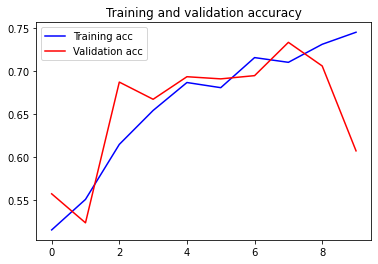

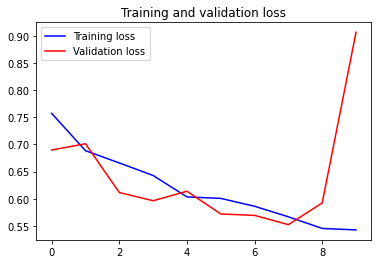

In [14]:
plot_training(first_history)

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

def show_errors(model, data_generator, data_dir, start=0, end=None):
  """
  Show misclassified images
  
  Adapted from: https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  
  data_generator generates images to classify
  - n.b., shuffle=False should be set when constructing this generator
  --- this is b/c when we ask the generator for .filenames and .classes  it is deterministic
  ---- the .classes form the "ground truth" against which predictions are evaluated so the order of examples must be deterministic
  Parameters
  -----------
  model: model for prediction
  data_generator: generator for data
  data_dir: the directory from which the generator obtains its data
  start, end: Integers.  Indices for first and last error (first error is 0)
  """

  # Get the filenames from the generator
  fnames = data_generator.filenames

  # Get the ground truth from generator
  ground_truth = data_generator.classes

  # Get the label to class mapping from the generator
  # i.e., { "class 0": 0, "class 1": 1, ... }
  label2index = xvalidation_generator.class_indices

  # Getting the mapping from class index to class label
  idx2label = dict((v,k) for k,v in label2index.items())

  # Get the predictions from the model using the generator
  predictions = model.predict_generator(data_generator, steps=data_generator.samples/data_generator.batch_size,verbose=1)

  # Handle special case where prediction is binary, not categorical
  # convert it into 2 categories
  if predictions.shape[-1] == 1:
    predictions = np.c_[ 1-predictions, predictions]

  predicted_classes = np.argmax(predictions,axis=1)

  # errors: list of indices where prediction is wrong
  errors = np.where(predicted_classes != ground_truth)[0]
  print("No of errors = {}/{}".format(len(errors),data_generator.samples))
  
  if end is None:
    end = len(errors)
    
  # Show the errors
  for i in range(start, end):
      pred_class = np.argmax(predictions[errors[i]])
      pred_label = idx2label[pred_class]

      title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
          fnames[errors[i]].split('/')[0],
          pred_label,
          predictions[errors[i]][pred_class])

      original = load_img('{}/{}'.format(data_dir,fnames[errors[i]]))
      plt.figure(figsize=[7,7])
      plt.axis('off')
      plt.title(title)
      plt.imshow(original)
      plt.show()


Found 800 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


50/50 [==============================] - 2s 42ms/step
No of errors = 218/800


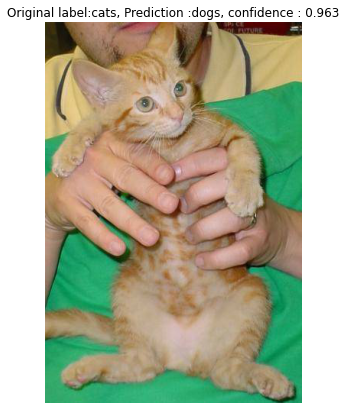

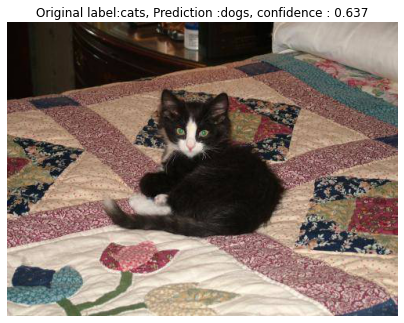

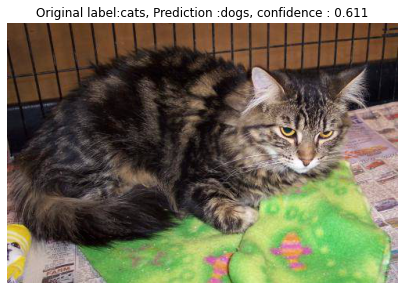

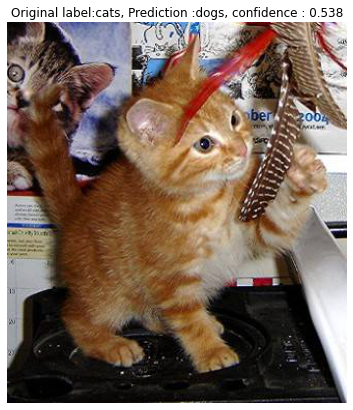

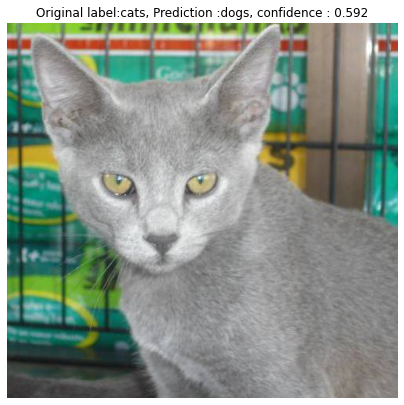

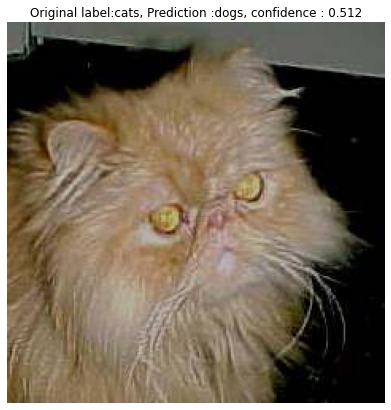

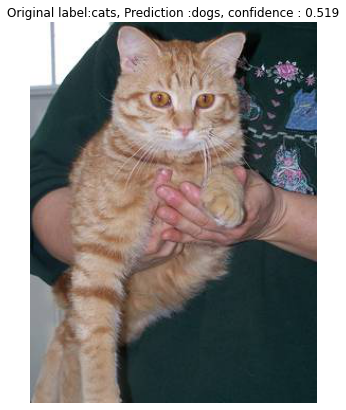

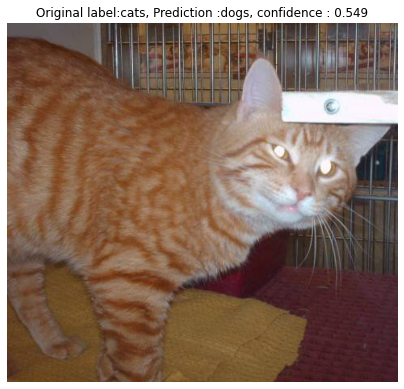

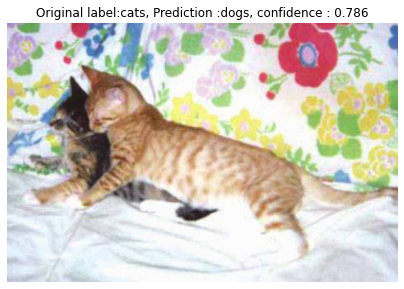

In [16]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Need validation set to NOT be shuffled
#- n.b., shuffle=False should be set when constructing this generator
#  --- this is b/c when we ask the generator for .filenames and .classes  it is deterministic
#  ---- the .classes form the "ground truth" against which predictions are evaluated so the order of examples must be deterministic
xvalidation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

show_errors(first_model, xvalidation_generator, validation_data_dir, start=1, end=10)

# Load a pre-trained VGG16 model

58892288/58889256 [==============================] - 1s 0us/step


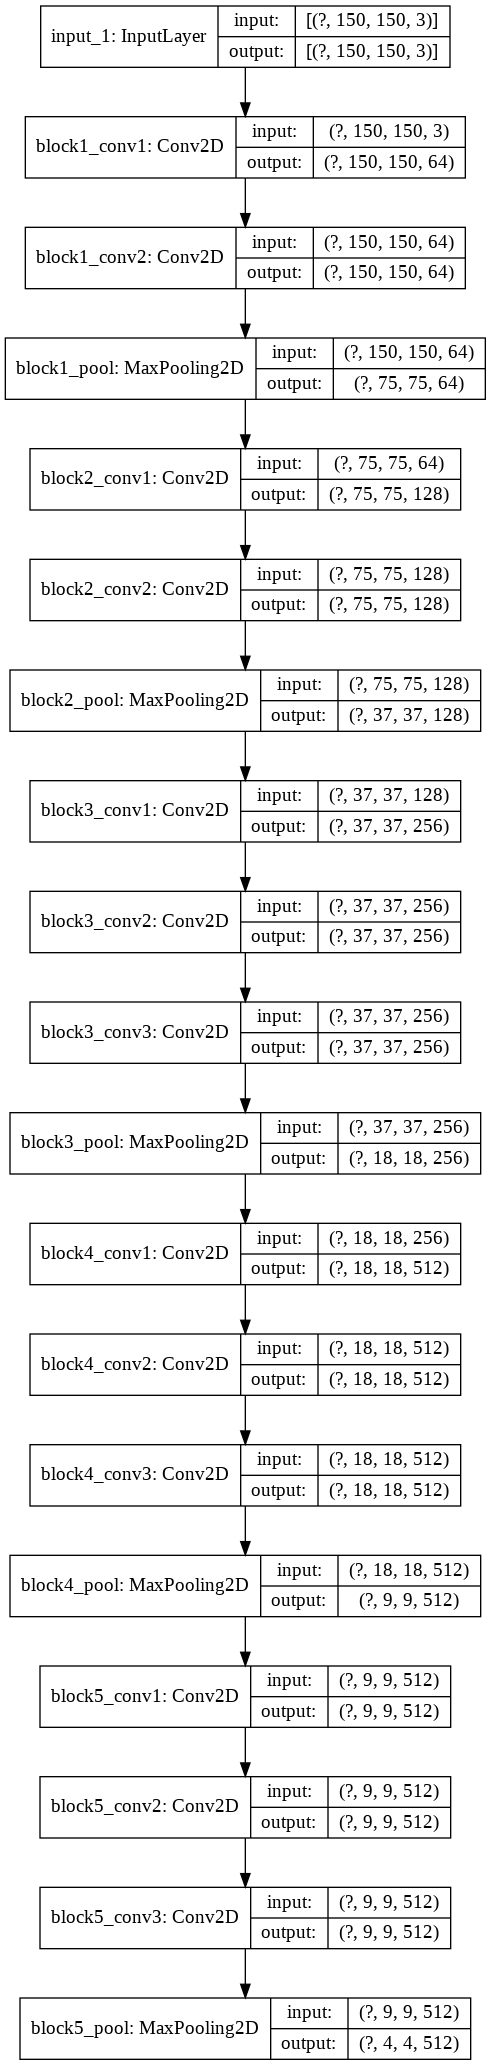

In [17]:
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                     include_top=False, 
                                     weights='imagenet')

plotFile = plotModel(base_model, "vgg16_model")
IPython.display.Image( plotFile) 



In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Transfer Learning: Graft a new head onto VGG 16

In [19]:
transf_model = createTransferModel(base_model,  base_model.layers[-1].name)
transf_model.summary()

Last layer block5_pool is index 18
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 19s 153ms/step - loss: 0.5173 - acc: 0.7335 - val_loss: 0.3131 - val_acc: 0.8662
Epoch 2/50
125/125 [==============================] - 19s 152ms/step - loss: 0.3549 - acc: 0.8465 - val_loss: 0.2793 - val_acc: 0.8813
Epoch 3/50
125/125 [==============================] - 19s 153ms/step - loss: 0.3103 - acc: 0.8760 - val_loss: 0.2355 - val_acc: 0.9038
Epoch 4/50
125/125 [==============================] - 19s 152ms/step - loss: 0.2788 - acc: 0.8885 - val_loss: 0.2402 - val_acc: 0.9075
Epoch 5/50
125/125 [==============================] - 19s 153ms/step - loss: 0.2476 - acc: 0.9010 - val_loss: 0.2881 - val_acc: 0.8800


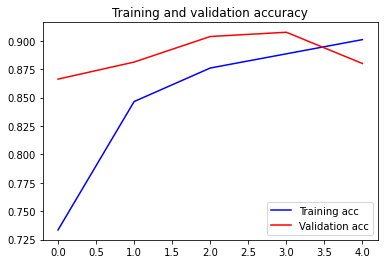

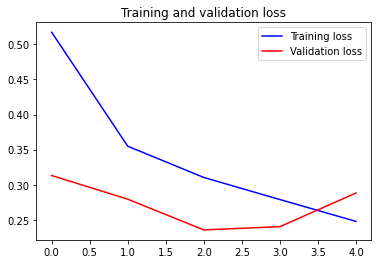

In [20]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)
plot_training(transf_history)

# Transfer Learning: Graft a new suffix onto a VGG16 prefix
- Do we do better or worse by elminating later layers of VGG 16 (perhaps too specialized ?)

In [21]:
transf_model = createTransferModel(base_model, 'block4_pool')

Last layer block4_pool is index 14


In [22]:
transf_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [23]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 19s 151ms/step - loss: 0.6846 - acc: 0.6280 - val_loss: 0.4062 - val_acc: 0.8313
Epoch 2/50
125/125 [==============================] - 19s 150ms/step - loss: 0.4251 - acc: 0.8110 - val_loss: 0.2759 - val_acc: 0.8775
Epoch 3/50
125/125 [==============================] - 19s 151ms/step - loss: 0.3217 - acc: 0.8715 - val_loss: 0.2342 - val_acc: 0.9162
Epoch 4/50
125/125 [==============================] - 19s 149ms/step - loss: 0.2724 - acc: 0.8940 - val_loss: 0.3174 - val_acc: 0.8813
Epoch 5/50
125/125 [==============================] - 19s 150ms/step - loss: 0.2418 - acc: 0.9100 - val_loss: 0.2388 - val_acc: 0.9150


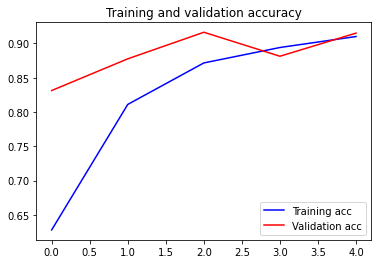

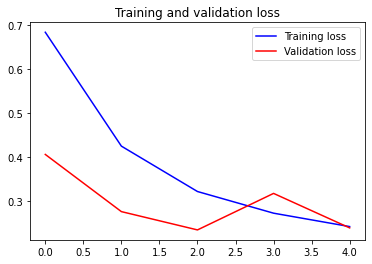

In [24]:
plot_training(transf_history)

# Transfer Learning: Graft a new head onto *an even shorter* prefix of VGG 16.
- Can we still learn ?

In [25]:
transf_model = createTransferModel(base_model, 'block3_pool')
transf_model.summary()

Last layer block3_pool is index 10
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 18s 145ms/step - loss: 2.1790 - acc: 0.5010 - val_loss: 0.6929 - val_acc: 0.5038
Epoch 2/50
125/125 [==============================] - 18s 143ms/step - loss: 0.7468 - acc: 0.5120 - val_loss: 0.6892 - val_acc: 0.5113
Epoch 3/50
125/125 [==============================] - 18s 144ms/step - loss: 0.7167 - acc: 0.5585 - val_loss: 0.6428 - val_acc: 0.6825
Epoch 4/50
125/125 [==============================] - 18s 145ms/step - loss: 0.6676 - acc: 0.6505 - val_loss: 0.6075 - val_acc: 0.7362
Epoch 5/50
125/125 [==============================] - 18s 144ms/step - loss: 0.6439 - acc: 0.6665 - val_loss: 0.5788 - val_acc: 0.7387
Epoch 6/50
125/125 [==============================] - 18s 145ms/step - loss: 0.5928 - acc: 0.7390 - val_loss: 0.7770 - val_acc: 0.7150
Epoch 7/50
125/125 [==============================] - 18s 143ms/step - loss: 0.5297 - acc: 0.7600 - val_los

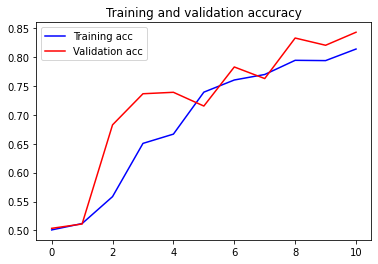

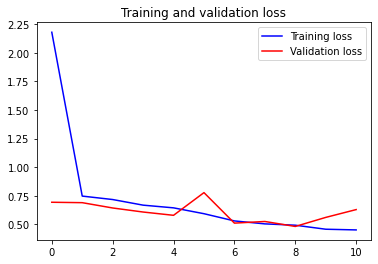

In [26]:
transf_history = trainModel(transf_model, train_data_dir, validation_data_dir)
plot_training(transf_history)